# M2M100 NMT English to Tagalog

#### gDrive mount

In [1]:
from google.colab import drive
drive.mount('/home')

Mounted at /home


#### Install Packages


In [2]:
!pip install datasets
!pip install transformers
!pip install accelerate -U
!pip install sentencepiece
!pip install /home/MyDrive/Colab_Notebooks/BLEU_repo/bleurt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
Processing /home/MyDrive/Colab_Notebooks/BLEU_repo/bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=2b9de279874f9d884fa2f24b5d1052b0e17a5b7812829a9969fccf1d0fe4617e
  Stored in directory: /tmp/pip-ephem-wheel-cache-y4b57lw_/wheels/62/91/0a/d9ec60c47372c14fd33c916db990c26ca55b74e63557172b20
Successfully built BLEURT


#### Import Libraries

In [3]:
import datasets
from datasets import load_dataset_builder
from datasets import get_dataset_split_names
from datasets import (get_dataset_config_names, load_dataset,
                      get_dataset_split_names, concatenate_datasets,
                      Dataset, DatasetDict)
from transformers import (M2M100ForConditionalGeneration, M2M100Tokenizer,
                          Seq2SeqTrainingArguments, Seq2SeqTrainer,
                          TrainerCallback, get_constant_schedule_with_warmup)
import torch
from sklearn.model_selection import train_test_split
import sentencepiece

import nltk
import nltk.translate.bleu_score as bleu
from bleurt import score as bleurt

from google.colab import runtime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import datetime
import json
import re
import random
import gc
from tqdm import tqdm as std_tqdm, trange
from functools import partial
tqdm = partial(std_tqdm, colour='#0000FF')


Installing CultraX

In [ ]:
# used link: https://huggingface.co/datasets/uonlp/CulturaX
# load culturax filipino dataset
import huggingface_hub
huggingface_hub.login()

get_dataset_split_names("uonlp/CulturaX", "tl")

ds_builder = load_dataset_builder("uonlp/CulturaX",
                  language="tl",
                  use_auth_token=True)
ds = load_dataset("uonlp/CulturaX",
                  language="tl",
                  use_auth_token=True)
dataset = ds['train']
print(dataset)

#print(ds_builder.info)")"
#print("Inspect dataset description")
#print(ds_builder.info)

# Inspect dataset features
#print(ds_builder.info.features)
#print("-----")


print(f"👉 Dataset len(datasets): {len(dataset)}")
print("\n👉 First item 'datasets[0]':")
print(dataset[0])

Installing Flores

In [ ]:
# SOURCE: https://huggingface.co/datasets/facebook/flores
# SOURCE: https://github.com/facebookresearch/flores/blob/main/flores200/README.md
# what are all the languages available in Flores200
languages = get_dataset_config_names('facebook/flores')

# load the English-Tagalog sentence pairs
flores_eng_tgl = load_dataset('facebook/flores', 'eng_Latn-tgl_Latn')

Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

In [ ]:
flores_eng_tgl['dev']
# call the first english-tagalog pair
print(flores_eng_tgl['dev']['sentence_eng_Latn'][0])
print(flores_eng_tgl['dev']['sentence_tgl_Latn'][0])

On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
Noong Lunes, inanunsiyo ng mga siyentipiko mula sa Stanford University School of Medicine ang imbensyon ng panibagong kagamitan sa pag-diagnose na makakauri sa mga cell ayon sa uri: isang maliit na chip na maaaring maprint na maaaring magawa gamit ang standard inkjet na mga printer at posibleng nasa isang U.S. sentimo kada isa.


#### Load Flores Dataset

In [ ]:
# Load splits into dictionaries
flores_splits = {
                'train_eng_inputs': None,
                'val_eng_inputs':   None,
                'test_eng_inputs':  None,
                'train_tgl_labels': None,
                'val_tgl_labels':   None,
                'test_tgl_labels':  None
}

for split in flores_splits:
    with open(f'../home/MyDrive/Colab_Notebooks/FloRes200/{split}.txt', 'r') as file:
        flores_splits[split] = file.read().splitlines()

#### Load Synthetic Dataset

In [ ]:
# load synthetic corpora from .json file
with open('../home/MyDrive/Colab_Notebooks/M2M100-Flores_Reverse/231206-112513/Synthetic_corpora_new.json', 'r') as json_file:
    synthetic_corpora = json.load(json_file)

synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100', 'synth_splits_200', 'synth_splits_300', 'synth_splits_400'])

Train Test Splits

In [ ]:
#train test splits
from sklearn.model_selection import train_test_split
# Define the input data and labels
input_data = flores_eng_tgl['dev']['sentence_eng_Latn']
labels = flores_eng_tgl['dev']['sentence_tgl_Latn']

# Split the data and labels into training and testing sets
train_data_engtgl, test_data_engtgl, train_labels_engtgl, test_labels_engtgl = train_test_split(input_data, labels, train_size=0.8, random_state=42)
train_data_tgleng, test_data_tgleng, train_labels_tgleng, test_labels_tgleng = train_test_split(labels, input_data, train_size=0.8, random_state=42)

# Print the sizes of the train and test datasets
print(f"Train dataset size: {len(train_data_engtgl)}")
print('First 5 items in train:', train_data_engtgl[:5])
print(f"Test dataset size: {len(test_data_engtgl)}")
print()
print(f"Train dataset size: {len(train_data_tgleng)}")
print('First 5 items in train:', train_data_tgleng[:5])
print(f"Test dataset size: {len(test_data_tgleng)}")

Train dataset size: 797
First 5 items in train: ['The Cook Islands do not have any cities but are composed of 15 different islands. The main ones are Rarotonga and Aitutaki.', 'Animal Liberation and the Royal Society for the Prevention of Cruelty to Animals (RSPCA) are again calling for the mandatory installation of CCTV cameras in all Australian abattoirs.', 'The Mumbai attackers arrived via boat on Novemeber 26, 2008, bringing with them grenades, automatic weapons and hit multiple targets including the crowded Chhatrapati Shivaji Terminus railway station and the famous Taj Mahal Hotel.', 'No airline alliance covers all three ocean crossings in the Southern Hemisphere (and SkyTeam covers none of the crossings).', 'Although some scholars speculate that since the civilisation also existed in the basins of the now dried up Sarasvati River, it should be aptly called the Indus-Sarasvati Civilization, while some call it the Harappan Civilization after Harappa, the first of its sites to be e

In [ ]:
#Guide: arxiv.org/abs/2010.11125


Model

In [ ]:
# Download m2m100
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

In [ ]:
# Save m2m100
model_path = "../home/MyDrive/Colab_Notebooks/M2M100-Stock"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('../home/MyDrive/Colab_Notebooks/M2M100-Stock/tokenizer_config.json',
 '../home/MyDrive/Colab_Notebooks/M2M100-Stock/special_tokens_map.json',
 '../home/MyDrive/Colab_Notebooks/M2M100-Stock/vocab.json',
 '../home/MyDrive/Colab_Notebooks/M2M100-Stock/sentencepiece.bpe.model',
 '../home/MyDrive/Colab_Notebooks/M2M100-Stock/added_tokens.json')

#### Model

In [ ]:
# Load m2m100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../home/MyDrive/Colab_Notebooks/M2M100-Stock"

model = M2M100ForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = M2M100Tokenizer.from_pretrained(model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Translator

In [4]:
def m2m100_translate(inputs, src_lang='en', tgt_lang='tl'):
  """
  This function pre-processes source sentences then translates them to target language.

  Inputs:
  inputs = the sentence(s) to be translated.
  scr_lang = the source language
  inputs = the sentence(s) to be translated.
  scr_lang = the source language
  trg_lang = the target language

  Output: The translated sentences.
  """

  tokenizer.src_lang = src_lang
  tokenizer.tgt_lang = tgt_lang
  sentences = inputs
  translated = []

  for sent in tqdm(sentences):
    encoded = tokenizer(sent, return_tensors="pt").to(device)
    with torch.no_grad():
      generated_tokens = model.generate(**encoded,
                                    forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])
    translated.append(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

  return translated

#### Scoring

In [ ]:
def bleu_bleurt(predicted_labels=None, true_labels=None, batch=64):
    """
    This function calculates the BLEU and BLEURT scores of predicted
    translations against the true labels.

    Formats:
        predicted_labels: list(list(str))
        true_labels: list(str)
    """

    scores_dict = {'bleu_score': None,
                   'bleurt_score': None}

    # flatten predicted_labels
    predicted_labels = list(map(lambda x: x[0], predicted_labels))

    # scoring with bleu
    smoothing = bleu.SmoothingFunction().method7
    scores_bleu = [bleu.sentence_bleu([str(predicted).split()], str(true).split(), smoothing_function=smoothing)
                    for predicted, true in zip(predicted_labels, true_labels)]
    scores_dict['bleu_score'] = np.mean(scores_bleu)

    # loading the bleurt model: checkpoint 20
    try:
        global bleurt_checkpoint, bleurt_scorer
        bleurt_checkpoint, bleurt_scorer
    except:
            bleurt_checkpoint = "/home/MyDrive/Colab_Notebooks/BLEU_repo/BLEURT-20"
            bleurt_scorer = bleurt.LengthBatchingBleurtScorer(bleurt_checkpoint)

    # scoring with bleurt
    scores_bleurt = []
    for i in std_tqdm(range(0,len(predicted_labels),batch), colour='#0000FF'):
        scores_bleurt.extend(bleurt_scorer.score(references=true_labels[i:i+batch],
                                                candidates=predicted_labels[i:i+batch],
                                                batch_size=batch))
    scores_dict['bleurt_score'] = np.mean(scores_bleurt)

    return scores_dict


In [ ]:
scores_engtgl = [bleu.sentence_bleu([str(predicted).split()], str(test).split()) for predicted, test in zip(translation, test_labels_engtgl)]
average = sum(scores_engtgl) / len(scores_engtgl)

print("First five scores:", scores_engtgl[:5])
print("Average BLEU Score:", average)
print("\n")


First five scores: [3.833106902373456e-155, 2.260382815963038e-78, 6.507961052388263e-155, 1.0832677820940877e-231, 2.678026972557048e-78]
Average BLEU Score: 9.876819577040172e-79




/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
print(translation[:5])
print(test_labels_engtgl[:5])
print(test_data_engtgl[:5])

[["Ang interactive design ay kailangan ng mga components ng isang proyekto upang makipag-ugnayan sa iba't ibang mga bagay, ngunit ito ay maaaring makikita bilang isang separated entity."], ["Ang mga supermarket ay nag-aalok ng isang mas mahusay na bahagi ng pag-aalok ng pagkain. Ang ilang ay nag-aalok ng isang microwave oven o iba't ibang paraan para sa pag-aalok ng pagkain."], ['Ang isang official sa gas na kumpanya ay tinatawag sa pangunahing lugar pagkatapos ng isang neighbor na tinatawag tungkol sa isang gas leak.'], ['Panatilihin ang pagpapatala para sa isang minimum na dalawang magkasunod na semestre.'], ['Ang Cook Islands ay isang isla na bansa sa libre-association sa New Zealand, na nagtatrabaho sa Polynesia, sa loob ng South Pacific Ocean.']]
['Kailangang ikabit ng magkaugnay na disenyo ang mga bahagi ng proyekto, subalit mayroon pa rin itong saysay bilang isang hiwalay na entidad.', "Mas dumaraming supermarket ang nagkakaroon ng iba't ibang seksyon ng mga pagkaing handa nang 

#### Training

In [ ]:
def m2m100_train(model_, tokenizer_, splits_dict, foldername, epochs=4,
                     batch_size=48, src_lang='en', tgt_lang='tl'):
    """
    This function trains m2m100.

    Inputs:
        splits_dict: dataset dictionary must contain these splits
        - train_eng_inputs
        - train_tgl_labels
        - val_eng_inputs
        - val_tgl_labels
        foldername: the name of the folder to save the model and logs
        batch_size: the batch size
        epochs: the number of epochs to train
        scr_lang = the source language code
        trg_lang = the target language code

    Returns: The trainer for the model.
    """
    start_time = time.time()

    dir = "../home/MyDrive/Colab_Notebooks"
    path = os.path.join(dir, foldername)
    os.makedirs(path, exist_ok=True)
    global log_dir
    log_dir = os.path.join(path, datetime.datetime.now().strftime("%y%m%d-%H%M%S"))

    tokenizer_.src_lang = src_lang
    tokenizer_.tgt_lang = tgt_lang

    lang_map = {"en": ('eng_inputs', 'tgl_labels'), "tl": ('tgl_labels', 'eng_inputs')}
    src, tgt = lang_map.get(src_lang)

    tokenized_train = tokenizer_(text = splits_dict[f'train_{src}'],
                                    text_target = splits_dict[f'train_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=128)

    tokenized_val = tokenizer_(text = splits_dict[f'val_{src}'],
                                    text_target = splits_dict[f'val_{tgt}'],
                                    return_tensors="pt", padding=True,
                                    pad_to_multiple_of=32, truncation=True,
                                    max_length=128)

    training_dataset = Dataset.from_dict(tokenized_train.to(device))
    validation_dataset = Dataset.from_dict(tokenized_val.to(device))

    sample_size = len(splits_dict[f'train_{src}'])
    total_steps = epochs*sample_size/batch_size if sample_size%batch_size == 0 else (epochs*sample_size//batch_size)+1
    warmup_steps = 0.85 * total_steps/epochs

    training_args = Seq2SeqTrainingArguments(

        # directories
        output_dir=path,
        logging_dir=log_dir,

        # logging settings
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=1,
        logging_strategy="steps",
        logging_steps=1,
        logging_first_step=True,

        # saving settings
        save_strategy="no",
        save_steps=4,
        save_total_limit=5,
        load_best_model_at_end=False,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=False,
        gradient_checkpointing_kwargs=False,

        # optimizer settings
        num_train_epochs=epochs,
        lr_scheduler_type='constant_with_warmup',
        learning_rate=2e-4,
        weight_decay=1e-2,
        warmup_steps=warmup_steps,

        # data loader settings
        sortish_sampler=True,
        group_by_length=True,
        dataloader_pin_memory=True,
        auto_find_batch_size=False,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,

        # trainer settings
        resume_from_checkpoint=None,
        report_to='tensorboard',
        predict_with_generate=False,
        tf32=False,
        fp16=False,
        max_steps=-1
    )

    class EarlyStopCallback(TrainerCallback):
        def __init__(self, patience=5, tolerance=1e-3):
            self.patience = patience
            self.tolerance = tolerance
            self.counter = 0
            self.prev_eval_loss = float('inf')  # Initialize with positive infinity

        def on_step_end(self, args, state, control, optimizer, **kwargs):
            if len(state.log_history) > 0:
                self.eval_loss = state.log_history[-1]["eval_loss"]
                self.diff = self.prev_eval_loss - self.eval_loss

                if self.diff < self.tolerance:
                    self.counter += 1
                    if self.counter >= self.patience:
                        print('Training stopped early due to lack of improvement in eval_loss.')
                        print(f"Learning Rate at stopping: {optimizer.param_groups[0]['lr']}")
                        control.should_training_stop = True
                else:
                    self.counter = 0

                self.prev_eval_loss = self.eval_loss

    optimizer_ = torch.optim.RAdam(model_.parameters(), lr=2e-4, weight_decay=0)

    scheduler_ = get_constant_schedule_with_warmup(optimizer_, num_warmup_steps=warmup_steps)

    trainer = Seq2SeqTrainer(
        model=model_,
        args=training_args,
        train_dataset=training_dataset,
        eval_dataset=validation_dataset,
        optimizers=(optimizer_, scheduler_),
        callbacks=[EarlyStopCallback]
    )

    trainer.place_model_on_device = True
    trainer.train()

    tokenized_train.to('cpu')
    tokenized_val.to('cpu')
    del training_dataset, validation_dataset
    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache
    end_time = time.time()
    print(f'Total Training Time: {round((end_time - start_time)/60,3)} mins')

    return trainer



#### Plotting

In [ ]:
def extract_metrics(trainer):
  """
  Function to retreive training metrics from trainer
  Input: Trainer() class object
  Output: Dictionary with train_loss, val_loss lists
  """
  metrics = {'train_loss': [],
             'val_loss':   []}

  for log in trainer.state.log_history:
      if 'loss' in log.keys():
          metrics['train_loss'].append(log['loss'])
      if 'eval_loss' in log.keys():
          metrics['val_loss'].append(log['eval_loss'])

  return metrics

def plot_metrics(metrics):
  """
  Function to plot training metrics
  Input: Dictionary with train_loss, val_loss lists
  Output: Plot of training metrics
  """
  train_loss = metrics['train_loss']
  val_loss = metrics['val_loss']

  steps = [i for i in range(len(train_loss))]
  plt.figure(figsize=(10, 5))
  plt.plot(steps, train_loss, label="Train Loss", marker='o', color='blue')
  plt.plot(steps, val_loss, label="Val Loss", marker='o', color='orange')
  plt.xlabel("Step")
  plt.ylabel("Metrics Value")
  plt.title(f"Training and Validation Metrics: model-{log_dir.split('/')[-1]}")
  plt.xticks(range(0, len(steps), 10), steps[::10])
  plt.legend()
  plt.savefig(f"loss_curves-model-{log_dir.split('/')[-1]}.png", format='png', dpi=300)
  plt.show()


# Experiments

In [ ]:
quit()

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

In [5]:
native_speaker_eval_eng = ['A bottle fell onto the floor and shattered.',
                           'Look at me.',
                           "Saying sorry for what happened, I don't think Hae Ra would want that.",
                           'CAPULET Why, how now, kinsman! wherefore storm you so?',
                           'And what of Irene Adler?']

native_speaker_eval_tgl = ['Bote isang nahulog papunta sa sahig at shattered.',
                           'Tignan mo ako.',
                           'Patawad sa nangyari, tingin ko ayaw mangyari ni Hae Ra yun',
                           'CAPULET Bakit, paano ngayon, kamag-anak! sa ganyan bagyo mo ito?',
                           '"At kung ano ng Irene Adler?"']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Load m2m100 Checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stock_path = "../home/MyDrive/Colab_Notebooks/M2M100-Stock"
checkpoint_path = "../home/MyDrive/Colab_Notebooks/M2M100-Flores_Reverse/231206-112513"


model = M2M100ForConditionalGeneration.from_pretrained(checkpoint_path).to(device)
tokenizer = M2M100Tokenizer.from_pretrained(stock_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Baseline

In [ ]:
# translate with stock model
baseline_translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

100%|██████████| 402/402 [05:35<00:00,  1.20it/s]


In [ ]:
# save translations
with open(os.path.join(model_path, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in baseline_translations:
        file.write(string[0] + '\n')

In [ ]:
# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


[['Ang isang bottle ay lumabas sa floor at lumabas.'],
 ['Tingnan sa akin.'],
 ['Sa tingin ko, hindi ko alam kung ano ang ginawa ni Hae Ra.'],
 ['Bakit, kung ano ngayon, kinsman! kung ano ang bumalik sa iyo?'],
 ['Ano ang ibig sabihin ni Irene Adler?']]

In [ ]:
bleu_bleurt(predicted_labels=baseline_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


{'bleu_score': 0.17301099884202814, 'bleurt_score': 0.3884182646870613}

#### Fine-tuning

In [ ]:
model_trainer = m2m100_train(model, tokenizer, flores_splits,
                             foldername="M2M100-Flores", epochs=10,
                             batch_size=48, src_lang='en', tgt_lang='tl')

Step,Training Loss,Validation Loss
1,9.135100,9.269574
2,9.441400,9.269341
3,9.252300,9.268860
4,9.629400,9.268141
5,9.612900,9.267182
6,9.511900,9.185992
7,9.569900,9.045427
8,9.661600,8.851357
9,9.133900,8.648203
10,8.904900,8.502309


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 12.614 mins


../home/MyDrive/Colab_Notebooks/M2M100-Flores/231206-085235 



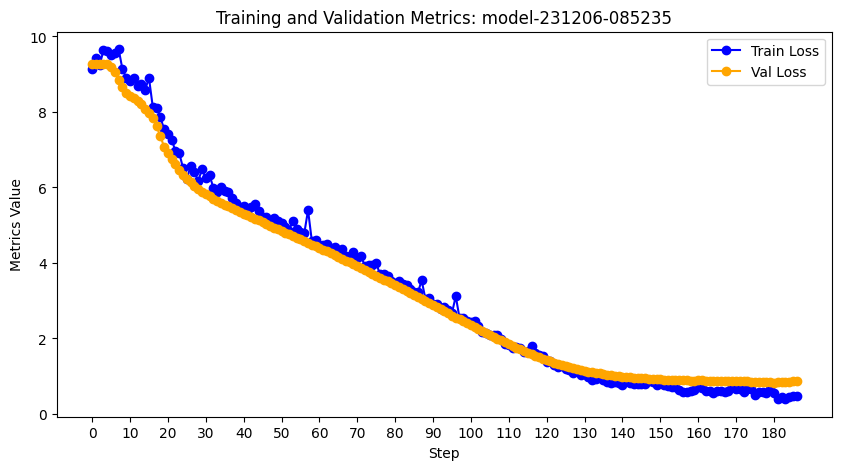

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


[['Ang isang botol ay humigit-kumulang sa lupa at humigit-kumulang.'],
 ['Tingnan sa akin.'],
 ['Subali ako sa kung ano ang nangyari, hindi ko alam na gusto ito ng Hae Ra.'],
 ['CAPULET Why, how now, kinsman! kung saan kailanman ang balahibo sa iyo?'],
 ['Ano pa rin kay Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


{'bleu_score': 0.2389033538594421, 'bleurt_score': 0.4311057218345837}

#### Reverse-training

In [ ]:
model_trainer = m2m100_train(model, tokenizer, flores_splits,
                             foldername="M2M100-Flores_Reverse", epochs=10,
                             batch_size=48, src_lang='tl', tgt_lang='en')

Step,Training Loss,Validation Loss
1,9.127100,9.219833
2,9.222300,9.219571
3,9.134000,9.219019
4,9.412900,9.218199
5,9.372000,9.217107
6,9.299400,9.105816
7,9.516700,8.923272
8,9.477300,8.701852
9,8.892700,8.513973
10,8.781000,8.407721


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 10.149 mins


../home/MyDrive/Colab_Notebooks/M2M100-Flores_Reverse/231206-112513 



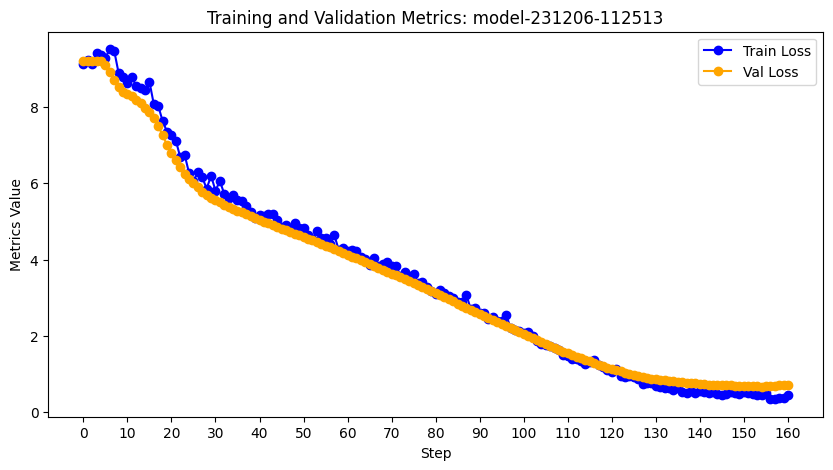

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_tgl_labels'],
                                         src_lang='tl', tgt_lang='en')

# save translations
with open(os.path.join(log_dir, 'flores_pred_test_eng_inputs.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

100%|██████████| 402/402 [04:42<00:00,  1.42it/s]


In [10]:
# translate native_eng_eval
translations = m2m100_translate(inputs=native_speaker_eval_tgl,
                                         src_lang='tl', tgt_lang='en')

# save translations
with open(os.path.join(log_dir, 'pred_native_eng_eval.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

In [11]:
translations

[['Boat a fall into the shattered shore.'],
 ['You indicated me.'],
 ["When it took place, look at I didn't have happened to Hae Ra."],
 ['CAPULET Why, how today, baby! in which hurricane you have it?'],
 ['What is Irene Adler?']]

In [12]:
native_speaker_eval_eng

['A bottle fell onto the floor and shattered.',
 'Look at me.',
 "Saying sorry for what happened, I don't think Hae Ra would want that.",
 'CAPULET Why, how now, kinsman! wherefore storm you so?',
 'And what of Irene Adler?']

In [ ]:
native_speaker_eval_eng

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_eng_inputs'])

100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


{'bleu_score': 0.24542992652773926, 'bleurt_score': 0.5880056389825261}

In [ ]:
# load real tgl samples
with open('../home/MyDrive/Colab_Notebooks/CulturaX/CulturaX_splits.json', 'r') as json_file:
    culturax_splits = json.load(json_file)
culturax_splits.keys()

dict_keys(['train_eng_inputs', 'train_tgl_labels'])

In [ ]:
# validate length of monolingual set before translating
if len(culturax_splits['train_tgl_labels']) != len(flores_splits['train_eng_inputs']):
    raise ValueError('Incorrect monolingual tgl sample size!')

culturax_back_translations = m2m100_translate(inputs=culturax_splits['train_tgl_labels'],
                                              src_lang='tl', tgt_lang='en')

100%|██████████| 1205/1205 [14:51<00:00,  1.35it/s]


In [ ]:
# flatten translation ouputs
culturax_back_translations = np.array(culturax_back_translations).flatten().tolist()

In [ ]:
# save english backtranslations
with open(os.path.join(log_dir, 'culturax_pred_test_eng_inputs.txt'), 'w') as file:
    for string in culturax_back_translations:
        file.write(string + '\n')

In [ ]:
# make dictionary of synth english and real monolingual tagalog
culturax_splits['train_eng_inputs'] = culturax_back_translations

In [ ]:
# Save splits as .json file in mydrive
with open(os.path.join(log_dir, 'CulturaX_splits.json'), 'w') as json_file:
    json.dump(culturax_splits, json_file)

In [ ]:
def corpus_collator(real_splits, synth_splits, frac=1.0):
    """
    Funtion to add `frac` of synthetic data to real data,
    and return combined splits dictionary.

    Args:
        - real_splits: dict of real data splits
        - synth_splits: dict of synthetic data splits
        - frac: fraction of synthetic data to incorporate
    Returns:
        dictionary of collated data
    """
    random.seed(1234)

    sample_size = int(round(len(real_splits['train_eng_inputs']) * frac, 0))

    real_pairs = []
    for i in range(len(real_splits['train_eng_inputs'])):
        real_pairs.append([real_splits['train_eng_inputs'][i], real_splits['train_tgl_labels'][i]])

    synth_pairs = []
    for i in range(len(synth_splits['train_eng_inputs'])):
        synth_pairs.append([synth_splits['train_eng_inputs'][i], synth_splits['train_tgl_labels'][i]])

    # sample from synth dict
    synth_pair_samples = random.sample(synth_pairs, sample_size)

    mixed_pairs = real_pairs + synth_pair_samples

    # shuffle mixed samples in-place
    for i in range(100):
        random.shuffle(mixed_pairs)

    mixed_eng_inputs = []
    mixed_tgl_labels = []
    for i in range(len(mixed_pairs)):
        mixed_eng_inputs.append(mixed_pairs[i][0])
        mixed_tgl_labels.append(mixed_pairs[i][1])

    combined_splits = {
        'train_eng_inputs': mixed_eng_inputs,
        'val_eng_inputs':   real_splits['val_eng_inputs'],
        'train_tgl_labels': mixed_tgl_labels,
        'val_tgl_labels':   real_splits['val_tgl_labels']
    }

    return combined_splits


In [ ]:
# create synthetic corpora with varying ratios of real:synth samples
synthetic_corpora = {
                f'synth_splits_{frac}': corpus_collator(flores_splits, culturax_splits, frac=frac/100)
                for frac in [i for i in range(0,101,25)]
}

synthetic_corpora.keys()

dict_keys(['synth_splits_0', 'synth_splits_25', 'synth_splits_50', 'synth_splits_75', 'synth_splits_100'])

In [ ]:
# save synthetic corpora
with open(os.path.join(log_dir, 'Synthetic_corpora.json'), 'w') as json_file:
    json.dump(synthetic_corpora, json_file)

#### Backtranslation 25%

In [ ]:
model_trainer = m2m100_train(model, tokenizer, synthetic_corpora['synth_splits_25'],
                             foldername="M2M100-Synthetic_25", epochs=10,
                             batch_size=48, src_lang='en', tgt_lang='tl')

Step,Training Loss,Validation Loss
1,9.455800,9.269574
2,9.283500,9.269394
3,9.485300,9.269011
4,9.951400,9.268452
5,9.109400,9.267668
6,9.514000,9.210629
7,9.310000,9.101652
8,9.274500,8.950321
9,9.046100,8.764330
10,9.144800,8.590664


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 13.626 mins


../home/MyDrive/Colab_Notebooks/M2M100-Synthetic_25/231206-121530 



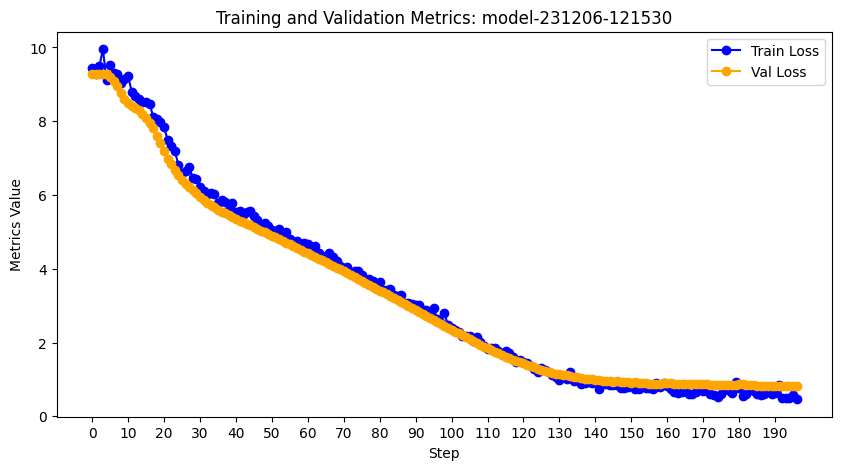

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


[['Ang isang butila ay bumabalik sa lupa at bumabalik.'],
 ['Tingnan sa akin.'],
 ['Nangangahulugang sa kung ano ang nangyayari, hindi ko ay sinasabing gusto ko ng Hae Ra na iyon.'],
 ['KAPULETANG Bakit, kung paano ngayon, kinsman! kung saan kailanman ang bagyo sa iyo?'],
 ['Ano ang tungkol sa Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


{'bleu_score': 0.25434286040264553, 'bleurt_score': 0.4568944116730002}

In [ ]:
runtime.unassign()

#### Backtranslation 50%

In [ ]:
model_trainer = m2m100_train(model, tokenizer, synthetic_corpora['synth_splits_50'],
                             foldername="M2M100-Synthetic_50", epochs=10,
                             batch_size=48, src_lang='en', tgt_lang='tl')

Step,Training Loss,Validation Loss
1,9.767400,9.269574
2,9.426000,9.269426
3,9.513500,9.269114
4,9.449000,9.268635
5,9.552200,9.267986
6,9.760700,9.217508
7,9.558000,9.128450
8,9.255000,8.999822
9,9.308200,8.842402
10,9.530800,8.682556


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 16.392 mins


../home/MyDrive/Colab_Notebooks/M2M100-Synthetic_50/231206-131944 



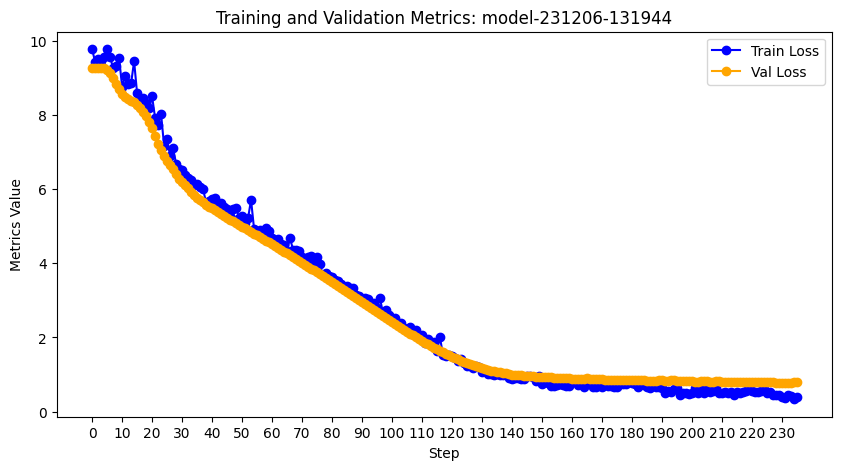

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


[['Ang isang botol ay nahulog sa lupa at binigyan.'],
 ['Tingnan ang akin.'],
 ['Sa pagsasalita ay humingi para sa kung ano ang nangyayari, hindi ko naniniwalang gusto itong si Hae Ra.'],
 ['KAPULET Bakit, kung paano ngayon, kinsman! kung bakit ba ang bagyong ikaw kaya?'],
 ['Ano ang tungkol sa Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


{'bleu_score': 0.256164176070152, 'bleurt_score': 0.48281641171049716}

In [ ]:
runtime.unassign()

#### Backtranslation 75%

In [ ]:
model_trainer = m2m100_train(model, tokenizer, synthetic_corpora['synth_splits_75'],
                             foldername="M2M100-Synthetic_75", epochs=10,
                             batch_size=48, src_lang='en', tgt_lang='tl')

Step,Training Loss,Validation Loss
1,9.517900,9.269574
2,9.431100,9.269444
3,9.534100,9.269175
4,9.478200,9.268764
5,9.698900,9.268210
6,9.566300,9.216841
7,9.257800,9.133151
8,9.402500,9.022448
9,9.401700,8.881542
10,9.166200,8.730236


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 17.751 mins


../home/MyDrive/Colab_Notebooks/M2M100-Synthetic_75/231206-194453 



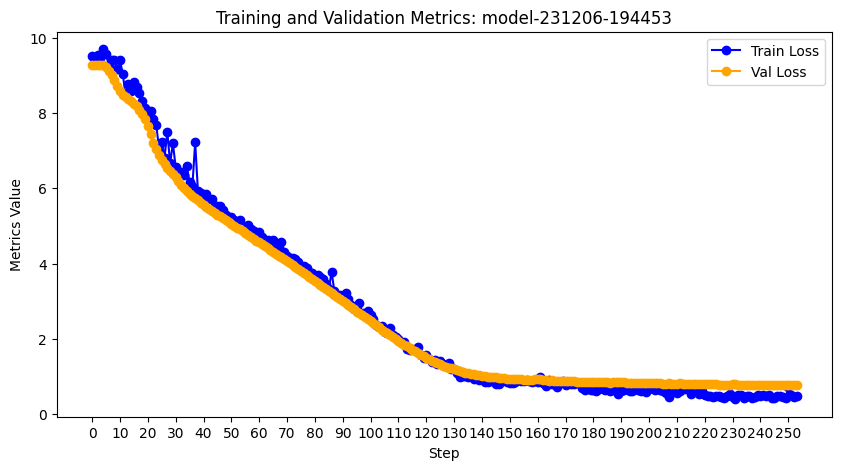

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


[['Ang isang botol ay nahuhulog sa lupa at nanirahan.'],
 ['Tingnan ang akin.'],
 ['Sinabi ng abala sa kung ano ang nangyayari, hindi ko lang alam na nais ko lang ito si Hae Ra.'],
 ['KAPULET Bakit, kung paano ngayon, kinsman! kung saan pa ang balahibo mo kaya?'],
 ['Ano ang tungkol kay Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


{'bleu_score': 0.26580773470445135, 'bleurt_score': 0.4882318068721994}

In [ ]:
runtime.unassign()

#### Backtranslation 100%

In [ ]:
model_trainer = m2m100_train(model, tokenizer, synthetic_corpora['synth_splits_100'],
                             foldername="M2M100-Synthetic_100", epochs=10,
                             batch_size=48, src_lang='en', tgt_lang='tl')

Step,Training Loss,Validation Loss
1,9.431700,9.269574
2,9.320300,9.269462
3,9.583400,9.269227
4,9.617900,9.268870
5,9.311900,9.268387
6,9.517600,9.227449
7,9.388200,9.160451
8,9.302400,9.064648
9,9.469600,8.939053
10,9.241700,8.798447


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 16.463 mins


../home/MyDrive/Colab_Notebooks/M2M100-Synthetic_100/231206-202937 



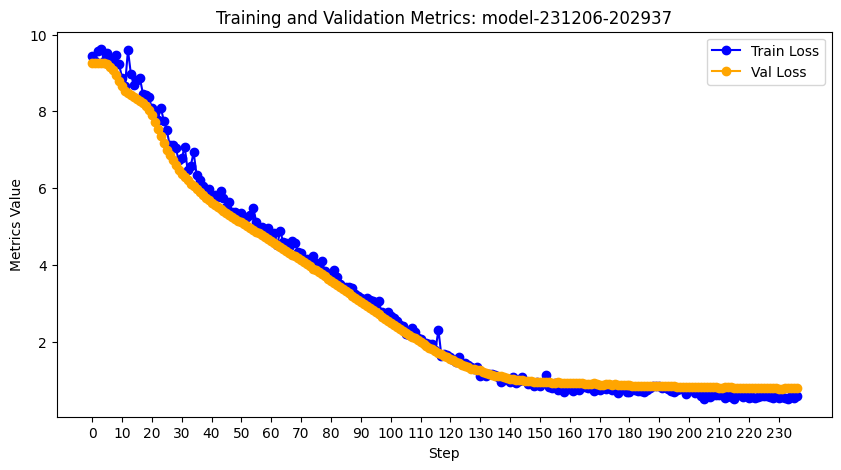

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


[['Ang isang butas ay nakakatakot sa lupa at nakakatakot.'],
 ['Tingnan ang akin.'],
 ['Ipinahiwatig sa kung ano ang nangyayari, hindi ko naniniwala na nais na ito si Hae Ra.'],
 ['KAPULET Bakit, kung paano ngayon, kinsman! kung ano ang bumuha sa iyo kaya?'],
 ['Ano ang tungkol ni Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


{'bleu_score': 0.2515728962148997, 'bleurt_score': 0.47635206398530977}

In [ ]:
runtime.unassign()

#### Backtranslation 200%

In [ ]:
model_trainer = m2m100_train(model, tokenizer, synthetic_corpora['synth_splits_200'],
                             foldername="M2M100-Synthetic_200", epochs=10,
                             batch_size=48, src_lang='en', tgt_lang='tl')

Step,Training Loss,Validation Loss
1,9.823400,9.269574
2,9.883800,9.269530
3,9.462200,9.269418
4,9.376300,9.269226
5,9.598900,9.268961
6,9.567900,9.253399
7,9.396400,9.215255
8,9.724300,9.167508
9,9.285800,9.095779
10,9.462200,9.007668


Training stopped early due to lack of improvement in eval_loss.
Learning Rate at stopping: 0.0002
Total Training Time: 17.94 mins


../home/MyDrive/Colab_Notebooks/M2M100-Synthetic_200/231207-060620 



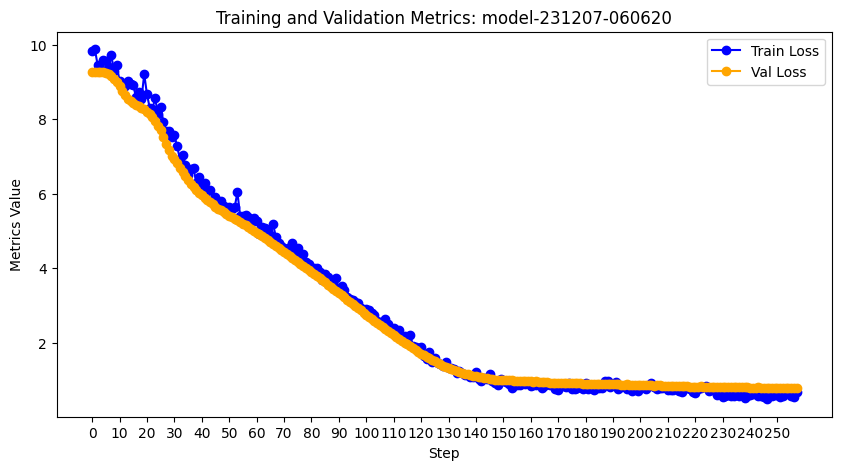

In [ ]:
# training directory
print(log_dir, '\n')

# Save the trained model + tokenizer
model_trainer.save_model(log_dir)

# visualize loss curve
metrics = extract_metrics(model_trainer)
plot_metrics(metrics)

In [ ]:
# translate test split
translations = m2m100_translate(inputs=flores_splits['test_eng_inputs'],
                                         src_lang='en', tgt_lang='tl')

# save translations
with open(os.path.join(log_dir, 'pred_test_tgl_labels.txt'), 'w') as file:
    for string in translations:
        file.write(string[0] + '\n')

# for native speaker evaluation
m2m100_translate(inputs=native_speaker_eval_eng, src_lang='en', tgt_lang='tl')

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


[['Ang isang butas ay bumagsak sa lupa at bumagsak.'],
 ['Tingnan sa akin.'],
 ['Sinabi ng apelsin para sa kung ano ang nangyari, hindi ko naisip ni Hae Ra na gusto iyon.'],
 ['CAPULET Bakit, kung paano ngayon, kinsman! kung saan pa ang bumubuo sa iyo kaya iyon?'],
 ['Ano ang tungkol kay Irene Adler?']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


{'bleu_score': 0.2632514670439979, 'bleurt_score': 0.45528638881830436}

# End

In [ ]:
# Load m2m100 Checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stock_path = "../home/MyDrive/Colab_Notebooks/M2M100-Stock"
checkpoint_path = "../home/MyDrive/Colab_Notebooks/M2M100-Flores_Reverse/231206-112513"

model = M2M100ForConditionalGeneration.from_pretrained(stock_path).to(device)
tokenizer = M2M100Tokenizer.from_pretrained(stock_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
path_translations =\
"/home/MyDrive/Colab_Notebooks/M2M100-Synthetic_100/231206-202937/pred_test_tgl_labels.txt"

with open(path_translations, 'r') as file:
    translations = file.read().splitlines()

prep_translations = [[x] for x in translations]
prep_translations[:3]

[['Noong 1994, ang etnikong rehiyon ng Nagorno-Karabakh ng Azerbaijan ay nagtagumpay ng digmaan laban sa mga Azerbaidjan.'],
 ['Si Zayat ay hindi nakakasakit sa aksidente.'],
 ['Ipinahihiwatig ng pinakamataas na lider ng bansa, Ayatollah Ali Khamenei, ang dependence sa langis bilang "bagyong trapiko" na nagmula noong nakalipas ng Rebolusyong Islamiko ng Iran noong 1979 at kung saan dapat libreng ang bansa ang kanyang sarili.']]

In [ ]:
# free up memory
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

# calculate scores
bleu_bleurt(predicted_labels=prep_translations, true_labels=flores_splits['test_tgl_labels'])

100%|██████████| 7/7 [00:27<00:00,  3.90s/it]


{'bleu_score': 0.27163150041934925, 'bleurt_score': 0.45484860335935406}